# Multivariate time series prediction using transformer with hyperparameter optimization
In this notebook, we use Optuna to find the optimum values of hyperparameters. In this notebook we specifically optimize the values of learning rate, weight decay, positional encoding dropout and encoder layer dropout.

Optuna is a python package specifially designed for hyperparameter tuning. We need to define a range of possible values for each of the hyperparameters. And optuna will try different parameter values with the model to minimize the validation loss after for specified number of experiments.

In [295]:
!pip install optuna

In [296]:
#!pip install plotly

In [297]:
# Important necessary libraries

import torch
import numpy as np
import math

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import optuna

import warnings
import os

#ignore warnings for the notebook
warnings.filterwarnings('ignore')

# Load Data

In [298]:
# Import daily data file
df = pd.read_csv('11447650_filled_daily_data.csv')
df = df.drop(columns=['SSD_st_d', 'Precip_in'])
df.head()

,DATE,SSC_mg_L,Discharge_cfs,Turb_fnu
0,2009-12-03,25.0,8440.0,4.225000
1,2009-12-04,20.0,8650.0,4.405208
2,2009-12-05,14.0,8520.0,4.281053
3,2009-12-06,11.0,8250.0,4.666667
4,2009-12-07,21.0,9190.0,4.757317


# Set up device for the model

In [299]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Implement determinism. Set a fixed value for random seed so that when the parameters are initialized, they are initialized same across all experiments.
torch.manual_seed(42)

# If you are using CUDA, also set the seed for it
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Set the seed for NumPy
np.random.seed(42)

Using device: cuda


# Define RiverData class

Here we define RiverData a custom Dataset class to load the dataset we have. It extends the Pytorch Dataset class.

We need to define __init__() function which can be used for loading data from the file and optionally for data preprocessing.
Thereafter we define __len__() function which gives the length of dataset.
Then we define __getitem__() function which returns an instance of (feature, label) tuple which can be used for model training. For our time series data, feature means the past values to be used for training and label means the future values to be predicted.


In [300]:
class RiverData(torch.utils.data.Dataset):

    def __init__(self, df, target, feature_cols, datecol, seq_len, pred_len):
        self.df = df
        self.datecol = datecol
        self.target = target
        self.feature_cols = feature_cols
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.setIndex()


    def setIndex(self):
        self.df.set_index(self.datecol, inplace=True)


    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len


    def __getitem__(self, idx):
        if len(self.df) <= (idx + self.seq_len+self.pred_len):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self.df)}")
        # df_piece = self.df[idx:idx+self.seq_len].values
        df_piece = self.df[self.feature_cols].iloc[idx:idx + self.seq_len].values
        feature = torch.tensor(df_piece, dtype=torch.float32)

        # Select only target column for label
        label_piece = self.df[self.target][idx + self.seq_len:  idx+self.seq_len+self.pred_len].values
        label = torch.tensor(label_piece, dtype=torch.float32)
        return (feature, label)

# Normalize Data

In [301]:
raw_df = df.drop('DATE', axis=1, inplace=False)
scaler = MinMaxScaler()

# Apply the transformations
df_scaled = scaler.fit_transform(raw_df)

df_scaled = pd.DataFrame(df_scaled, columns=raw_df.columns)
df_scaled['DATE'] = df['DATE']
df = df_scaled

Some advanced Python syntax has been used here.
*common_args : it's used to pass arguments to a function, where common_args represents a python list
**common_args: it's used to pass arguments to a function, where common_args represents a python dictionary

In [302]:
df_scaled.head()

,SSC_mg_L,Discharge_cfs,Turb_fnu,DATE
0,0.041308,0.044633,0.008162,2009-12-03
1,0.032702,0.046919,0.008562,2009-12-04
2,0.022375,0.045504,0.008286,2009-12-05
3,0.017212,0.042565,0.009144,2009-12-06
4,0.034423,0.052798,0.009345,2009-12-07


# Set up parameters (test & train size, sequence lenght, etc.)

In [303]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

seq_len = 7
pred_len = 1
num_features = 2
num_layers = 1


target_col = 'SSC_mg_L'
feature_cols = ['Turb_fnu', 'Discharge_cfs'] # exclude 'Precip_in', 'SSD_st_d'

common_args = [target_col, feature_cols, 'DATE',  seq_len, pred_len]
train_dataset = RiverData(df[:train_size], *common_args)
val_dataset = RiverData(df[train_size: train_size+val_size], *common_args)
test_dataset = RiverData(df[train_size+val_size : len(df)], *common_args)

In [304]:
# Important parameters

BATCH_SIZE = 128 # keep as big as can be handled by GPU and memory
SHUFFLE = False # we don't shuffle the time series data
DATA_LOAD_WORKERS = 1 # it depends on amount of data you need to load
learning_rate = 1e-3

In [305]:
from torch.utils.data import DataLoader

common_args = {'batch_size': BATCH_SIZE, 'shuffle': SHUFFLE}
train_loader = DataLoader(train_dataset, **common_args)
val_loader = DataLoader(val_dataset, **common_args)
test_loader = DataLoader(test_dataset, **common_args)

# Postitional Encoding

In [306]:
# The transformer implementation in pytorch doesn't implement the 
# positional encoding which is an essential part of the transforemer model

# Provide more description of positional encoding
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, pos_enc_dropout, max_len=5000):
        super().__init__();
        self.dropout = torch.nn.Dropout(p=pos_enc_dropout)

        Xp = torch.zeros(max_len, d_model) # max_len x d_model
        position = torch.arange(0, max_len).unsqueeze(1) # max_len x 1

        # Generates an exponentially decreasing series of numbers
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) #length: d_model/2

        #Applying sine to even indices in the array; 2i
        Xp[:, 0::2] = torch.sin(position.float() * div_term)

        #Applying cosine to odd indices in the array; 2i + 1
        Xp[:, 1::2] = torch.cos(position.float() * div_term)

        Xp = Xp.unsqueeze(1)
        self.register_buffer('Xp', Xp)

    def forward(self, x):
        x  = x + self.Xp[:x.size(0)]
        return self.dropout(x)
        

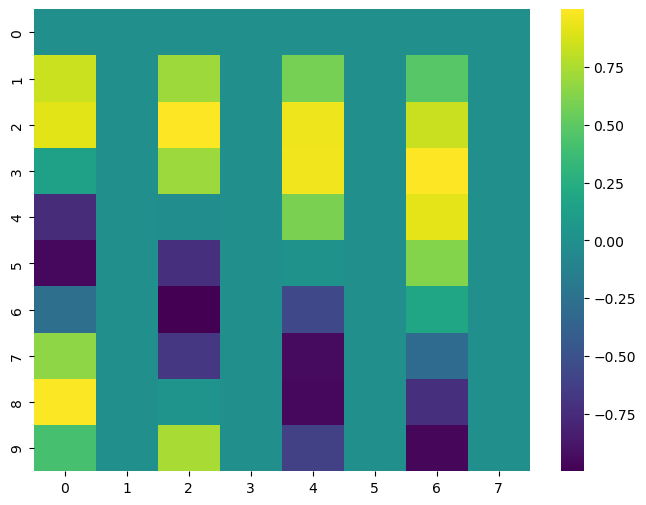

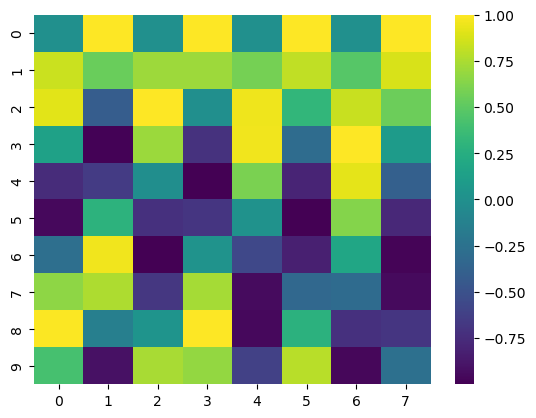

Positional encoding applied for our 3 timesteps


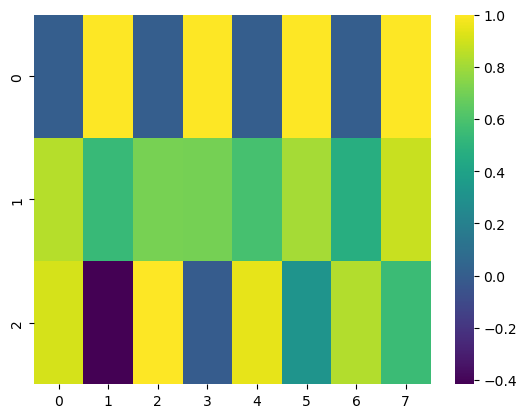

In [307]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import SymLogNorm

plt.figure(figsize=(8, 6))

xp = torch.zeros(10, 8)
maxlen = 10
position = torch.arange(0, 10).unsqueeze(1)
# print('position', position)
div_term = torch.exp(torch.arange(0, 8, 2)*(-math.log(9.0/8)))
# print('div_term', div_term)
xp[:, 0::2] = torch.sin(position.float() * div_term)
#evens
# print(xp)
# Generate the heatmap using seaborn
sns.heatmap(xp, cmap='viridis', annot=False)

# Display the plot
plt.show()
#odds
xp[:, 1::2] = torch.cos(position.float() * div_term)

sns.heatmap(xp, cmap='viridis', annot=False)

# Display the plot
plt.show()

print('Positional encoding applied for our 3 timesteps')
sns.heatmap(xp[:3], cmap='viridis', annot=False)

# Display the plot
plt.show()

# Define PyTorch model

BasicTransformerNetwork is the model class, it extends the Module class provided by Pytorch. \

We define __init__() function. It sets up layers and defines the model parameters.
Also, we define forward() function which defines how the forwared pass computation occurs
We also implement PositionalEncoding class which is an important part of transformer

In [308]:
class BasicTransformerNetwork(torch.nn.Module):
    
    def __init__(self, seq_len, pred_len, enc_layer_dropout, pos_enc_dropout):
        # call the constructor of the base class
        super().__init__()
        self.model_type = 'Transformer'
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_features = num_features

        # I don't think the embedding size should be this big. We will see.
        self.embedding_size = 128 #The features are converted to 128 embeddings
        self.num_layers = num_layers
        self.pos_encoder = PositionalEncoding(self.embedding_size, pos_enc_dropout, 10000)
        
        # dim_feedforward = 4 * d_model
        # layer_norm_eps: A very small number (epsilon) added to the denominator during the Layer Normalization calculation.
        self.encLayer = torch.nn.TransformerEncoderLayer(d_model=self.embedding_size, nhead=8, 
                                                 dim_feedforward=256, dropout=enc_layer_dropout, activation="relu", 
                                                 layer_norm_eps=1e-05, batch_first=True)
        
        self.transformerEnc = torch.nn.TransformerEncoder(self.encLayer, num_layers=self.num_layers)

        self.input_fc = torch.nn.Linear(self.num_features, self.embedding_size)
        
        self.prediction_head = torch.nn.Linear(self.embedding_size, self.pred_len)

        # Create causal mask
        self.register_buffer('causal_mask', self._generate_causal_mask(seq_len))


    def _generate_causal_mask(self, seq_len):
        """
        Generate causal mask for transformer encoder.
        Returns upper triangular matrix with -inf in upper triangle (excluding diagonal)
        """
        mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)
        return mask

    
    def forward(self, x):
        x = self.input_fc(x) * np.sqrt(self.embedding_size)
        x = self.pos_encoder(x)
        out = self.transformerEnc(x, mask=self.causal_mask)
        last_embedding = out[:, -1, :]
        prediction = self.prediction_head(last_embedding)
        prediction = prediction.squeeze(-1)
        return prediction
# Note that the gradients are stored inside the FC layer objects
# For each training example we need to get rid of these gradients

In [309]:
print(torch.__version__)

2.2.2+cu121


In [310]:
loss = torch.nn.MSELoss()

In [311]:
for i, (f,l) in enumerate(train_loader):
    print('features shape: ', f.shape)
    print('labels shape: ', l.shape)
    break

features shape:  torch.Size([128, 7, 2])
labels shape:  torch.Size([128, 1])


# Define Metrics

In [312]:
# define metrics
import numpy as np
epsilon = np.finfo(float).eps

def wape_function(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    y = np.array(y)
    y_pred = np.array(y_pred)
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator) * 100.0
    return wape

def nse_function(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))


def evaluate_model(model, data_loader, plot=False):
    # following line prepares the model for evaulation mode. It disables dropout and batch normalization if they have 
    # are part of the model. For our simple model it's not necessary. Still I'm going to use it.

    model.eval()
    all_outputs = torch.empty(0, pred_len)
    all_labels = torch.empty(0, pred_len)
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs).detach().cpu().unsqueeze(1)
        all_outputs = torch.vstack((all_outputs, outputs))
        all_labels = torch.vstack((all_labels, labels))    
   
    avg_val_loss = loss(all_outputs, all_labels)
    nse = nse_function(all_labels.numpy(), all_outputs.numpy())
    wape = wape_function(all_labels.numpy(), all_outputs.numpy())
        
    print(f'NSE : {nse}', end=' ')
    print(f'WAPE : {wape}', end=' ')
    print(f'Validation Loss: {avg_val_loss}')
    model.train()

    if plot:
        plt.figure(figsize=(16, 6))
        plt.title(f"Transform Model with Optuna Optimization, seq_len={seq_len}")
        plt.plot(np.array(all_labels.cpu()[:400]), color='green', label='observations')
        plt.plot(np.array(all_outputs.cpu()[:400]), color='red', linestyle='-', label='predictions')
        metrics_text = f"NSE: {nse:.3f}\nWAPE: {wape:.3f}" 
        plt.text(0.28, 0.97, metrics_text, transform=plt.gca().transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.legend()

        # Optional: save the plot with prediction
        plt.savefig(f"transformerOptuna_prediction_seqlen{seq_len}.jpg", format='jpg', dpi=300)
        
        plt.show()

    return avg_val_loss

# Optuna

In [313]:
from optuna.samplers import TPESampler
def objective(trial):
    # Here we define the search space of the hyper-parameters. Optuna uses byaesian optimization to find the optimal values of the hyperparameters.
    learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    pos_enc_dropout = trial.suggest_uniform('pos_enc_dropout', 0.05, 0.3)
    enc_layer_dropout = trial.suggest_uniform('enc_layer_dropout', 0.1, 0.5)
    # num_layers = trial.suggest_int("num_layers", 1, 4)

    
    model = BasicTransformerNetwork(seq_len, pred_len, pos_enc_dropout, enc_layer_dropout)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
    
    num_epochs = 300
    best_val_loss = float('inf')
    patience = 10
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = []
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs).unsqueeze(1)
            loss_val = loss(outputs, labels)
    
            # calculate gradients for back propagation
            loss_val.backward()
    
            # update the weights based on the gradients
            optimizer.step()
    
            # reset the gradients, avoid gradient accumulation
            optimizer.zero_grad()
            epoch_loss.append(loss_val.item())
    
        avg_train_loss = sum(epoch_loss)/len(epoch_loss)
        print(f'Epoch {epoch+1}: Traning Loss: {avg_train_loss}', end=' ')
        avg_val_loss = evaluate_model(model, val_loader)
    
        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model_trial_transformerOpt.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping!')
                # Load the best model before stopping
                model.load_state_dict(torch.load('best_model_trial_transformerOpt.pth'))
                break

        # Report intermediate objective value
        trial.report(best_val_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_loss

# Default sampler is TPESampler (Tree-structured Parzen Estimator). 
# This sampler is based on independent sampling and uses a Bayesian optimization approach to efficiently explore 
# the hyperparameter search space by building probability models of objective values.

study = optuna.create_study(direction='minimize', sampler=TPESampler())

# normally you run 100s of trials.
study.optimize(objective, n_trials=200)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value (Best Validation Loss):', trial.value)
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2025-08-08 04:44:33,359] A new study created in memory with name: no-name-c6132da4-126f-400a-b61d-79316abe9cad


Epoch 1: Traning Loss: 1.3986783398847495 NSE : -16.831174850463867 WAPE : 257.45506153677036 Validation Loss: 0.0038174695800989866
Epoch 2: Traning Loss: 0.014973750429427517 NSE : -1.1911373138427734 WAPE : 68.74541035550324 Validation Loss: 0.0004690996720455587
Epoch 3: Traning Loss: 0.0096419935580343 NSE : -1.9319331645965576 WAPE : 87.27335228373481 Validation Loss: 0.0006276963977143168
Epoch 4: Traning Loss: 0.008639561361633241 NSE : -0.20792841911315918 WAPE : 55.41725938021046 Validation Loss: 0.0002586049376986921
Epoch 5: Traning Loss: 0.009455276798689738 NSE : -2.767864942550659 WAPE : 114.08708037565371 Validation Loss: 0.0008066606824286282
Epoch 6: Traning Loss: 0.008599544536472032 NSE : -0.42270326614379883 WAPE : 49.77806208674714 Validation Loss: 0.0003045859921257943
Epoch 7: Traning Loss: 0.006963959668480259 NSE : -0.058506131172180176 WAPE : 43.65645608212417 Validation Loss: 0.00022661515686195344
Epoch 8: Traning Loss: 0.006678987130206744 NSE : -0.4304288

[I 2025-08-08 04:44:55,788] Trial 0 finished with value: 0.00022661515686195344 and parameters: {'lr': 0.010249928834786363, 'weight_decay': 0.003965575914409997, 'pos_enc_dropout': 0.15175071307637805, 'enc_layer_dropout': 0.31419729610992464}. Best is trial 0 with value: 0.00022661515686195344.


Epoch 17: Traning Loss: 0.004575614149091832 NSE : -0.439386248588562 WAPE : 66.44048657584956 Validation Loss: 0.0003081575850956142
Early stopping!
Epoch 1: Traning Loss: 0.23777148819395474 NSE : -26.624725341796875 WAPE : 285.1232666158482 Validation Loss: 0.0059141661040484905
Epoch 2: Traning Loss: 0.09558223773326192 NSE : -15.707839965820312 WAPE : 224.62381141661177 Validation Loss: 0.0035769750829786062
Epoch 3: Traning Loss: 0.05891044976721917 NSE : -9.05438232421875 WAPE : 176.96775282296514 Validation Loss: 0.002152538625523448
Epoch 4: Traning Loss: 0.03562276903539896 NSE : -4.253247261047363 WAPE : 125.77907495114376 Validation Loss: 0.001124665723182261
Epoch 5: Traning Loss: 0.02468286085474704 NSE : -7.578639984130859 WAPE : 172.4017785267818 Validation Loss: 0.0018365976866334677
Epoch 6: Traning Loss: 0.01985546261338251 NSE : -5.79551887512207 WAPE : 154.2449518223918 Validation Loss: 0.0014548501931130886
Epoch 7: Traning Loss: 0.016116457425856164 NSE : -3.9333

[I 2025-08-08 04:45:38,144] Trial 1 finished with value: 0.00010161715181311592 and parameters: {'lr': 0.00022615059381390863, 'weight_decay': 0.00031857848057071086, 'pos_enc_dropout': 0.14695917907574002, 'enc_layer_dropout': 0.3922084352613614}. Best is trial 1 with value: 0.00010161715181311592.


Epoch 32: Traning Loss: 0.005996188830717334 NSE : 0.5120007991790771 WAPE : 31.87733117790181 Validation Loss: 0.00010447555541759357
Early stopping!
Epoch 1: Traning Loss: 0.07852385725293841 NSE : -19.992591857910156 WAPE : 247.9111150693814 Validation Loss: 0.004494294989854097
Epoch 2: Traning Loss: 0.0411991932030235 NSE : -14.519027709960938 WAPE : 221.27049739956433 Validation Loss: 0.0033224625512957573
Epoch 3: Traning Loss: 0.02628759417815932 NSE : -22.43805694580078 WAPE : 288.5460712807427 Validation Loss: 0.005017844494432211
Epoch 4: Traning Loss: 0.02081589277700654 NSE : -6.083387851715088 WAPE : 143.70370199965132 Validation Loss: 0.0015164796495810151
Epoch 5: Traning Loss: 0.016911533661186695 NSE : -10.459956169128418 WAPE : 197.11197261914015 Validation Loss: 0.0024534573312848806
Epoch 6: Traning Loss: 0.014272247540897556 NSE : -13.114433288574219 WAPE : 223.59205029617738 Validation Loss: 0.003021753393113613
Epoch 7: Traning Loss: 0.01279121041963143 NSE : -5

[I 2025-08-08 04:46:05,665] Trial 2 finished with value: 0.0006573811988346279 and parameters: {'lr': 0.00014361248578152844, 'weight_decay': 0.006192830598808357, 'pos_enc_dropout': 0.11051657236797176, 'enc_layer_dropout': 0.26960994760118184}. Best is trial 1 with value: 0.00010161715181311592.


Epoch 20: Traning Loss: 0.007323385232926479 NSE : -5.675567150115967 WAPE : 150.67015177026974 Validation Loss: 0.001429169555194676
Early stopping!
Epoch 1: Traning Loss: 0.09787807147949934 NSE : -2.9307827949523926 WAPE : 100.83235960432562 Validation Loss: 0.0008415397023782134
Epoch 2: Traning Loss: 0.04426486610567996 NSE : -4.149194717407227 WAPE : 125.70610073334076 Validation Loss: 0.001102388952858746
Epoch 3: Traning Loss: 0.024961410822080716 NSE : -10.183385848999023 WAPE : 202.05622646228187 Validation Loss: 0.002394246868789196
Epoch 4: Traning Loss: 0.017143130468736802 NSE : -6.622217655181885 WAPE : 165.10437317841743 Validation Loss: 0.001631837454624474
Epoch 5: Traning Loss: 0.013358000250134085 NSE : -1.170689582824707 WAPE : 77.44565096830921 Validation Loss: 0.00046472207759507
Epoch 6: Traning Loss: 0.011520707181521825 NSE : -4.914335250854492 WAPE : 144.43653338122695 Validation Loss: 0.0012661977671086788
Epoch 7: Traning Loss: 0.010401093800153052 NSE : 0.

[I 2025-08-08 04:46:41,390] Trial 3 finished with value: 0.0001088737408281304 and parameters: {'lr': 0.0002604222022879513, 'weight_decay': 2.6128319111320848e-05, 'pos_enc_dropout': 0.22470772987836996, 'enc_layer_dropout': 0.30955858090577126}. Best is trial 1 with value: 0.00010161715181311592.


Epoch 27: Traning Loss: 0.00501300796583694 NSE : -0.40906810760498047 WAPE : 64.3824854647222 Validation Loss: 0.000301666819723323
Early stopping!
Epoch 1: Traning Loss: 0.07175661690000977 NSE : -52.49626541137695 WAPE : 423.9976232851018 Validation Loss: 0.01145299430936575
Epoch 2: Traning Loss: 0.03423916854496513 NSE : -1.796252965927124 WAPE : 82.39317476626806 Validation Loss: 0.0005986486794427037
Epoch 3: Traning Loss: 0.023407221206330826 NSE : -0.8196154832839966 WAPE : 66.80564522370517 Validation Loss: 0.00038956079515628517
Epoch 4: Traning Loss: 0.018152035972369567 NSE : -5.099833011627197 WAPE : 141.3329190295103 Validation Loss: 0.0013059108750894666
Epoch 5: Traning Loss: 0.014210327328847987 NSE : -1.4780378341674805 WAPE : 86.33390576713222 Validation Loss: 0.0005305221420712769
Epoch 6: Traning Loss: 0.011565916473045945 NSE : 0.27393555641174316 WAPE : 40.45867442604488 Validation Loss: 0.00015544287452939898
Epoch 7: Traning Loss: 0.010001206870323845 NSE : -0

[I 2025-08-08 04:47:04,234] Trial 4 finished with value: 0.00015544287452939898 and parameters: {'lr': 0.0003013095647282398, 'weight_decay': 3.6421975707541274e-05, 'pos_enc_dropout': 0.1802328263152395, 'enc_layer_dropout': 0.13587535145295565}. Best is trial 1 with value: 0.00010161715181311592.


Epoch 16: Traning Loss: 0.005505436740349978 NSE : -1.1445419788360596 WAPE : 80.03223452444587 Validation Loss: 0.0004591241304297
Early stopping!
Epoch 1: Traning Loss: 1.1192805688562137 NSE : -10.752498626708984 WAPE : 208.0182907141006 Validation Loss: 0.002516087843105197
Epoch 2: Traning Loss: 0.010091076713121896 NSE : -0.2887001037597656 WAPE : 58.130323638437645 Validation Loss: 0.000275897269602865
Epoch 3: Traning Loss: 0.009459624083579652 NSE : -0.20769214630126953 WAPE : 45.393557958963214 Validation Loss: 0.0002585543552413583
Epoch 4: Traning Loss: 0.00917358126025647 NSE : -5.836941719055176 WAPE : 151.57868981948042 Validation Loss: 0.0014637180138379335
Epoch 5: Traning Loss: 0.008354338280956395 NSE : -1.2904584407806396 WAPE : 71.31468286942972 Validation Loss: 0.0004903633380308747
Epoch 6: Traning Loss: 0.0075661184174740425 NSE : -2.5995473861694336 WAPE : 101.17108748673738 Validation Loss: 0.0007706256583333015


[I 2025-08-08 04:47:14,222] Trial 5 pruned. 


Epoch 7: Traning Loss: 0.007357864253987957 NSE : -1.8573355674743652 WAPE : 85.54608491924772 Validation Loss: 0.000611725787166506
Epoch 1: Traning Loss: 0.14661017645682609 NSE : -6.389925479888916 WAPE : 138.69810774780464 Validation Loss: 0.0015821062261238694


[I 2025-08-08 04:47:18,029] Trial 6 pruned. 


Epoch 2: Traning Loss: 0.07680828869342804 NSE : -33.86642074584961 WAPE : 351.1779642510136 Validation Loss: 0.007464538794010878


[I 2025-08-08 04:47:19,996] Trial 7 pruned. 


Epoch 1: Traning Loss: 1.1755875197372265 NSE : -80.98600006103516 WAPE : 565.247873255894 Validation Loss: 0.01755235157907009
Epoch 1: Traning Loss: 0.3315335781579571 NSE : -4.032234191894531 WAPE : 108.29824156947313 Validation Loss: 0.0010773490648716688
Epoch 2: Traning Loss: 0.024947326197954162 NSE : -1.7770802974700928 WAPE : 78.90548861094456 Validation Loss: 0.0005945439916104078
Epoch 3: Traning Loss: 0.018026074677306627 NSE : -1.4314384460449219 WAPE : 80.68043323121982 Validation Loss: 0.0005205456982366741
Epoch 4: Traning Loss: 0.015243209632379668 NSE : -0.1764681339263916 WAPE : 50.46465400673807 Validation Loss: 0.00025186961283907294
Epoch 5: Traning Loss: 0.011077695892059378 NSE : 0.21922600269317627 WAPE : 37.50147682004617 Validation Loss: 0.00016715559468138963
Epoch 6: Traning Loss: 0.00911108763622386 NSE : -1.1900572776794434 WAPE : 84.51898225203267 Validation Loss: 0.00046886850032024086
Epoch 7: Traning Loss: 0.008551277769064265 NSE : -3.318174839019775

[I 2025-08-08 04:47:48,711] Trial 8 finished with value: 0.00010757637210190296 and parameters: {'lr': 0.00193993371093169, 'weight_decay': 1.1194849682525033e-05, 'pos_enc_dropout': 0.18084231257978933, 'enc_layer_dropout': 0.18368260902908157}. Best is trial 1 with value: 0.00010161715181311592.


Epoch 22: Traning Loss: 0.004404600528817225 NSE : -1.7698791027069092 WAPE : 95.77917025635952 Validation Loss: 0.0005930022452957928
Early stopping!


[I 2025-08-08 04:47:50,718] Trial 9 pruned. 


Epoch 1: Traning Loss: 1.639866650636707 NSE : -405.9055480957031 WAPE : 1264.799067849262 Validation Loss: 0.08711425215005875


[I 2025-08-08 04:47:52,399] Trial 10 pruned. 


Epoch 1: Traning Loss: 6.028863969658103 NSE : -666.8739624023438 WAPE : 1620.9910723660719 Validation Loss: 0.14298488199710846


[I 2025-08-08 04:47:54,080] Trial 11 pruned. 


Epoch 1: Traning Loss: 0.17282137048563787 NSE : -23.03484344482422 WAPE : 266.3771086073591 Validation Loss: 0.005145610310137272
Epoch 1: Traning Loss: 0.19392813037016562 NSE : -2.6825520992279053 WAPE : 88.49524730964056 Validation Loss: 0.0007883961079642177


[I 2025-08-08 04:47:57,745] Trial 12 pruned. 


Epoch 2: Traning Loss: 0.027059551128851517 NSE : -58.656219482421875 WAPE : 480.78122671286894 Validation Loss: 0.01277177780866623
Epoch 1: Traning Loss: 0.15102091577968427 NSE : -4.429521560668945 WAPE : 122.99397720332101 Validation Loss: 0.0011624041944742203


[I 2025-08-08 04:48:00,542] Trial 13 pruned. 


Epoch 2: Traning Loss: 0.03311935349899743 NSE : -9.829553604125977 WAPE : 197.06694912065328 Validation Loss: 0.002318494487553835


[I 2025-08-08 04:48:02,369] Trial 14 pruned. 


Epoch 1: Traning Loss: 0.08503038329737526 NSE : -49.40825271606445 WAPE : 421.143100617167 Validation Loss: 0.010791882872581482
Epoch 1: Traning Loss: 0.4119132300838828 NSE : -0.6507565975189209 WAPE : 64.47830417842714 Validation Loss: 0.00035340976319275796
Epoch 2: Traning Loss: 0.024205475513424193 NSE : -0.801990270614624 WAPE : 72.58755796980829 Validation Loss: 0.00038578739622607827
Epoch 3: Traning Loss: 0.01065927349762725 NSE : -7.46994686126709 WAPE : 176.83797341017345 Validation Loss: 0.0018133274279534817
Epoch 4: Traning Loss: 0.007900254684500396 NSE : -0.26776885986328125 WAPE : 58.60049877491718 Validation Loss: 0.0002714160946197808
Epoch 5: Traning Loss: 0.006752038657266114 NSE : 0.5031428635120392 WAPE : 32.23278266089204 Validation Loss: 0.00010637194645823911
Epoch 6: Traning Loss: 0.007283538654779217 NSE : 0.5027291476726532 WAPE : 33.2622802824518 Validation Loss: 0.00010646051669027656
Epoch 7: Traning Loss: 0.0067812112143396264 NSE : 0.4724988341331482

[I 2025-08-08 04:48:22,285] Trial 15 finished with value: 0.00010637194645823911 and parameters: {'lr': 0.0028741410074222865, 'weight_decay': 0.00017923309010355382, 'pos_enc_dropout': 0.15834645245572138, 'enc_layer_dropout': 0.49632055006272646}. Best is trial 1 with value: 0.00010161715181311592.


Epoch 15: Traning Loss: 0.0056253332544916445 NSE : 0.09661942720413208 WAPE : 49.52863765630672 Validation Loss: 0.00019340436847414821
Early stopping!


[I 2025-08-08 04:48:24,280] Trial 16 pruned. 


Epoch 1: Traning Loss: 0.5728577073729996 NSE : -112.56446838378906 WAPE : 665.4735987298773 Validation Loss: 0.024312974885106087


[I 2025-08-08 04:48:26,349] Trial 17 pruned. 


Epoch 1: Traning Loss: 1.4745716274316822 NSE : -210.85264587402344 WAPE : 911.5431212556757 Validation Loss: 0.04535544291138649


[I 2025-08-08 04:48:28,313] Trial 18 pruned. 


Epoch 1: Traning Loss: 0.1076381779941065 NSE : -36.923152923583984 WAPE : 372.77728107693576 Validation Loss: 0.008118954487144947


[I 2025-08-08 04:48:30,462] Trial 19 pruned. 


Epoch 1: Traning Loss: 0.3800828040444425 NSE : -36.239845275878906 WAPE : 374.5140050192985 Validation Loss: 0.007972664199769497
Epoch 1: Traning Loss: 0.160850640386343 NSE : -16.105785369873047 WAPE : 215.3256702462539 Validation Loss: 0.0036621708422899246


[I 2025-08-08 04:48:34,022] Trial 20 pruned. 


Epoch 2: Traning Loss: 0.09302205845181431 NSE : -11.327924728393555 WAPE : 182.97965512986073 Validation Loss: 0.002639280166476965
Epoch 1: Traning Loss: 0.7516420109729681 NSE : -7.66464900970459 WAPE : 173.59513128375633 Validation Loss: 0.0018550112145021558


[I 2025-08-08 04:48:37,747] Trial 21 pruned. 


Epoch 2: Traning Loss: 0.01697487836437566 NSE : -9.722391128540039 WAPE : 196.59543478157278 Validation Loss: 0.0022955522872507572
Epoch 1: Traning Loss: 0.26318303402513266 NSE : -6.877780914306641 WAPE : 144.60012971368505 Validation Loss: 0.0016865507932379842
Epoch 2: Traning Loss: 0.03169588348828256 NSE : -0.8219016790390015 WAPE : 68.16582729610394 Validation Loss: 0.00039005023427307606
Epoch 3: Traning Loss: 0.01575431294207062 NSE : -6.735569953918457 WAPE : 166.74122382742132 Validation Loss: 0.0016561050433665514
Epoch 4: Traning Loss: 0.01150269791417356 NSE : 0.4080730676651001 WAPE : 35.80407860314103 Validation Loss: 0.00012672539742197841
Epoch 5: Traning Loss: 0.009116961820317166 NSE : -0.7118202447891235 WAPE : 70.0710073153326 Validation Loss: 0.0003664829127956182
Epoch 6: Traning Loss: 0.007907204097136855 NSE : 0.479106068611145 WAPE : 35.03010987541143 Validation Loss: 0.00011151797662023455
Epoch 7: Traning Loss: 0.007707014638331852 NSE : 0.5181689858436584

[I 2025-08-08 04:49:01,837] Trial 22 finished with value: 0.00010315501276636496 and parameters: {'lr': 0.0013778726137342158, 'weight_decay': 7.090603976124955e-05, 'pos_enc_dropout': 0.12755556156393597, 'enc_layer_dropout': 0.3577394243440391}. Best is trial 1 with value: 0.00010161715181311592.


Epoch 17: Traning Loss: 0.005167012805551556 NSE : -1.255608081817627 WAPE : 84.64107973579422 Validation Loss: 0.0004829022800549865
Early stopping!


[I 2025-08-08 04:49:04,811] Trial 23 pruned. 


Epoch 1: Traning Loss: 0.1355373171557273 NSE : -13.78762149810791 WAPE : 221.34360307283734 Validation Loss: 0.0031658762600272894


[I 2025-08-08 04:49:06,504] Trial 24 pruned. 


Epoch 1: Traning Loss: 0.7727731687731908 NSE : -143.9278106689453 WAPE : 753.3072799546347 Validation Loss: 0.03102753683924675


[I 2025-08-08 04:49:08,224] Trial 25 pruned. 


Epoch 1: Traning Loss: 0.22374854077185904 NSE : -14.972278594970703 WAPE : 230.60289915180002 Validation Loss: 0.0034194989129900932


[I 2025-08-08 04:49:10,412] Trial 26 pruned. 


Epoch 1: Traning Loss: 0.1047928631970925 NSE : -12.710602760314941 WAPE : 206.92259293942809 Validation Loss: 0.00293529755435884
Epoch 1: Traning Loss: 0.12928957984383618 NSE : -7.583198547363281 WAPE : 149.26875430003165 Validation Loss: 0.001837573479861021


[I 2025-08-08 04:49:13,483] Trial 27 pruned. 


Epoch 2: Traning Loss: 0.044632655302328725 NSE : -17.2199764251709 WAPE : 250.71364709891745 Validation Loss: 0.0039007074665278196


[I 2025-08-08 04:49:15,289] Trial 28 pruned. 


Epoch 1: Traning Loss: 0.838367524323985 NSE : -114.16098022460938 WAPE : 671.0420524405447 Validation Loss: 0.024654770269989967


[I 2025-08-08 04:49:17,566] Trial 29 pruned. 


Epoch 1: Traning Loss: 1.50316260818259 NSE : -139.75140380859375 WAPE : 742.0924194395692 Validation Loss: 0.030133413150906563


[I 2025-08-08 04:49:19,328] Trial 30 pruned. 


Epoch 1: Traning Loss: 0.13427349951650416 NSE : -38.92363357543945 WAPE : 388.3000030727716 Validation Loss: 0.008547235280275345


[I 2025-08-08 04:49:21,037] Trial 31 pruned. 


Epoch 1: Traning Loss: 0.3265750212594867 NSE : -40.552520751953125 WAPE : 388.73663241649166 Validation Loss: 0.008895963430404663


[I 2025-08-08 04:49:22,822] Trial 32 pruned. 


Epoch 1: Traning Loss: 0.4510492140959416 NSE : -14.0496826171875 WAPE : 220.49734205255555 Validation Loss: 0.0032219805289059877


[I 2025-08-08 04:49:24,609] Trial 33 pruned. 


Epoch 1: Traning Loss: 0.06886454299092293 NSE : -13.988729476928711 WAPE : 183.14049089744813 Validation Loss: 0.0032089308369904757


[I 2025-08-08 04:49:26,724] Trial 34 pruned. 


Epoch 1: Traning Loss: 0.6985179060138762 NSE : -15.296112060546875 WAPE : 241.31085094247823 Validation Loss: 0.003488828195258975
Epoch 1: Traning Loss: 1.0678696386250002 NSE : -8.587353706359863 WAPE : 184.21089992607273 Validation Loss: 0.002052552532404661


[I 2025-08-08 04:49:30,072] Trial 35 pruned. 


Epoch 2: Traning Loss: 0.011464916236166443 NSE : -12.61217975616455 WAPE : 224.6374170577604 Validation Loss: 0.0029142266139388084
Epoch 1: Traning Loss: 0.10143670586070844 NSE : -4.143983840942383 WAPE : 112.7999423567764 Validation Loss: 0.0011012734612450004


[I 2025-08-08 04:49:33,696] Trial 36 pruned. 


Epoch 2: Traning Loss: 0.06169742758252791 NSE : -1.82106351852417 WAPE : 83.03639459711445 Validation Loss: 0.0006039604195393622
Epoch 1: Traning Loss: 0.1515150472654828 NSE : -4.498373508453369 WAPE : 122.8916226879653 Validation Loss: 0.001177144469693303


[I 2025-08-08 04:49:36,658] Trial 37 pruned. 


Epoch 2: Traning Loss: 0.0216041131809886 NSE : -4.519592761993408 WAPE : 126.63225381553609 Validation Loss: 0.0011816875776275992
Epoch 1: Traning Loss: 1.3410631835992848 NSE : -9.625748634338379 WAPE : 195.55940135836224 Validation Loss: 0.0022748622577637434
Epoch 2: Traning Loss: 0.018246529690389122 NSE : -0.9645339250564575 WAPE : 79.0174065117453 Validation Loss: 0.0004205862933304161
Epoch 3: Traning Loss: 0.014486345445870288 NSE : -14.929494857788086 WAPE : 244.16808487948245 Validation Loss: 0.0034103395882993937


[I 2025-08-08 04:49:42,242] Trial 38 pruned. 


Epoch 4: Traning Loss: 0.01352909573220781 NSE : -2.949902057647705 WAPE : 117.44864322344588 Validation Loss: 0.0008456329233013093


[I 2025-08-08 04:49:44,924] Trial 39 pruned. 


Epoch 1: Traning Loss: 0.1831844486296177 NSE : -322.1393127441406 WAPE : 1107.0025507290768 Validation Loss: 0.06918075680732727


[I 2025-08-08 04:49:48,126] Trial 40 pruned. 


Epoch 1: Traning Loss: 0.07874773708837372 NSE : -30.31816864013672 WAPE : 305.42403344490066 Validation Loss: 0.006704894360154867
Epoch 1: Traning Loss: 0.1323885710111686 NSE : -4.075223922729492 WAPE : 114.22158396939979 Validation Loss: 0.0010865525109693408
Epoch 2: Traning Loss: 0.04832695344729083 NSE : -1.4396710395812988 WAPE : 77.9811759053297 Validation Loss: 0.0005223082262091339


[I 2025-08-08 04:49:53,037] Trial 41 pruned. 


Epoch 3: Traning Loss: 0.030549887168620313 NSE : -5.122623920440674 WAPE : 140.8306605423754 Validation Loss: 0.0013107899576425552


[I 2025-08-08 04:49:54,831] Trial 42 pruned. 


Epoch 1: Traning Loss: 0.10154582427016326 NSE : -41.877254486083984 WAPE : 374.1702818290254 Validation Loss: 0.009179574437439442
Epoch 1: Traning Loss: 0.12122297965522323 NSE : -9.439764976501465 WAPE : 164.856990415746 Validation Loss: 0.0022350449580699205


[I 2025-08-08 04:49:58,451] Trial 43 pruned. 


Epoch 2: Traning Loss: 0.043712506869009564 NSE : -3.400137424468994 WAPE : 109.83454521583427 Validation Loss: 0.0009420236456207931


[I 2025-08-08 04:50:01,198] Trial 44 pruned. 


Epoch 1: Traning Loss: 0.11457826316888843 NSE : -20.361894607543945 WAPE : 275.9678860859479 Validation Loss: 0.004573360085487366
Epoch 1: Traning Loss: 0.13113020899306452 NSE : -32.40447235107422 WAPE : 348.5484604839106 Validation Loss: 0.007151550147682428


[I 2025-08-08 04:50:03,057] Trial 45 pruned. 
[I 2025-08-08 04:50:05,288] Trial 46 pruned. 


Epoch 1: Traning Loss: 0.2735941279679537 NSE : -37.80065155029297 WAPE : 375.9454236325057 Validation Loss: 0.008306817151606083
Epoch 1: Traning Loss: 1.3811853759024026 NSE : -0.21396350860595703 WAPE : 45.82117849500247 Validation Loss: 0.00025989694404415786
Epoch 2: Traning Loss: 0.013255588859984917 NSE : -38.23444747924805 WAPE : 387.96498880738835 Validation Loss: 0.008399687707424164
Epoch 3: Traning Loss: 0.008423903283463525 NSE : -10.167832374572754 WAPE : 202.29820311874818 Validation Loss: 0.0023909166920930147
Epoch 4: Traning Loss: 0.008349477862274008 NSE : -4.900235652923584 WAPE : 144.8699256339974 Validation Loss: 0.0012631792342290282
Epoch 5: Traning Loss: 0.00840419075185699 NSE : -1.0178484916687012 WAPE : 79.32244892996069 Validation Loss: 0.00043200040818192065


[I 2025-08-08 04:50:13,094] Trial 47 pruned. 


Epoch 6: Traning Loss: 0.008115318429190665 NSE : -0.12488114833831787 WAPE : 44.34069412760481 Validation Loss: 0.00024082536401692778


[I 2025-08-08 04:50:14,941] Trial 48 pruned. 


Epoch 1: Traning Loss: 0.14307853260210582 NSE : -30.367813110351562 WAPE : 303.06401339136875 Validation Loss: 0.006715522613376379


[I 2025-08-08 04:50:17,521] Trial 49 pruned. 


Epoch 1: Traning Loss: 3.808862045141203 NSE : -1352.8922119140625 WAPE : 2308.993246639546 Validation Loss: 0.2898542284965515


[I 2025-08-08 04:50:20,109] Trial 50 pruned. 


Epoch 1: Traning Loss: 1.3912626363869225 NSE : -292.2621765136719 WAPE : 1073.2041662839395 Validation Loss: 0.06278438121080399


[I 2025-08-08 04:50:22,421] Trial 51 pruned. 


Epoch 1: Traning Loss: 0.09758111994181361 NSE : -29.598587036132812 WAPE : 312.6490232612098 Validation Loss: 0.006550839636474848


[I 2025-08-08 04:50:24,238] Trial 52 pruned. 


Epoch 1: Traning Loss: 0.06858044982488666 NSE : -50.50476837158203 WAPE : 422.5976882569678 Validation Loss: 0.011026634834706783


[I 2025-08-08 04:50:25,931] Trial 53 pruned. 


Epoch 1: Traning Loss: 0.09460532745080334 NSE : -23.551128387451172 WAPE : 282.03587058274707 Validation Loss: 0.005256142001599073


[I 2025-08-08 04:50:27,513] Trial 54 pruned. 


Epoch 1: Traning Loss: 0.19098221883177757 NSE : -246.27047729492188 WAPE : 969.012166368071 Validation Loss: 0.05293804034590721
Epoch 1: Traning Loss: 0.36632933700457215 NSE : -1.5026051998138428 WAPE : 72.07675487712118 Validation Loss: 0.0005357817863114178
Epoch 2: Traning Loss: 0.025300451388050402 NSE : -11.355860710144043 WAPE : 211.37410238507877 Validation Loss: 0.002645261352881789
Epoch 3: Traning Loss: 0.011266873301272946 NSE : -0.0046443939208984375 WAPE : 49.98879752916299 Validation Loss: 0.0002150839427486062
Epoch 4: Traning Loss: 0.008239315107597836 NSE : 0.3988211154937744 WAPE : 34.764023464144124 Validation Loss: 0.0001287061459152028
Epoch 5: Traning Loss: 0.006951047124208084 NSE : 0.4100240468978882 WAPE : 36.813960603781545 Validation Loss: 0.0001263077137991786
Epoch 6: Traning Loss: 0.006924453158197659 NSE : 0.47651606798171997 WAPE : 32.643277013975855 Validation Loss: 0.00011207247007405385
Epoch 7: Traning Loss: 0.006899490503461233 NSE : 0.4078580141

[I 2025-08-08 04:50:49,199] Trial 55 finished with value: 0.00011207247007405385 and parameters: {'lr': 0.0026334764397215106, 'weight_decay': 4.495681646040579e-05, 'pos_enc_dropout': 0.15797815877280535, 'enc_layer_dropout': 0.4643620794251307}. Best is trial 1 with value: 0.00010161715181311592.


Epoch 16: Traning Loss: 0.005500113999005407 NSE : -2.0827817916870117 WAPE : 103.17805101162378 Validation Loss: 0.0006599915213882923
Early stopping!


[I 2025-08-08 04:50:50,893] Trial 56 pruned. 


Epoch 1: Traning Loss: 0.3650052076471703 NSE : -12.045890808105469 WAPE : 200.32295322600763 Validation Loss: 0.002792989369481802


[I 2025-08-08 04:50:52,735] Trial 57 pruned. 


Epoch 1: Traning Loss: 0.3861210265729044 NSE : -8.271245956420898 WAPE : 181.97860529361319 Validation Loss: 0.0019848772790282965


[I 2025-08-08 04:50:54,295] Trial 58 pruned. 


Epoch 1: Traning Loss: 0.23090425366535783 NSE : -44.69862747192383 WAPE : 408.48896702455966 Validation Loss: 0.009783602319657803


[I 2025-08-08 04:50:56,327] Trial 59 pruned. 


Epoch 1: Traning Loss: 0.40083026367106606 NSE : -109.4977035522461 WAPE : 656.6284859731263 Validation Loss: 0.023656411096453667


[I 2025-08-08 04:50:58,022] Trial 60 pruned. 


Epoch 1: Traning Loss: 0.14451279996761254 NSE : -36.39167404174805 WAPE : 369.01877200544027 Validation Loss: 0.008005169220268726


[I 2025-08-08 04:50:59,549] Trial 61 pruned. 


Epoch 1: Traning Loss: 0.7975508656485805 NSE : -201.58140563964844 WAPE : 891.573063525363 Validation Loss: 0.0433705672621727
Epoch 1: Traning Loss: 0.3082882563716599 NSE : -65.19317626953125 WAPE : 501.6639797716323 Validation Loss: 0.014171269722282887


[I 2025-08-08 04:51:01,626] Trial 62 pruned. 
[I 2025-08-08 04:51:03,115] Trial 63 pruned. 


Epoch 1: Traning Loss: 0.1933647140062281 NSE : -76.43077087402344 WAPE : 542.609795305758 Validation Loss: 0.01657712273299694


[I 2025-08-08 04:51:04,813] Trial 64 pruned. 


Epoch 1: Traning Loss: 0.09257225399570805 NSE : -51.80677795410156 WAPE : 447.70821355138287 Validation Loss: 0.011305381543934345


[I 2025-08-08 04:51:06,461] Trial 65 pruned. 


Epoch 1: Traning Loss: 0.449568999532078 NSE : -151.2598419189453 WAPE : 770.7834959629204 Validation Loss: 0.03259725123643875


[I 2025-08-08 04:51:08,376] Trial 66 pruned. 


Epoch 1: Traning Loss: 0.1303565830790571 NSE : -36.18811798095703 WAPE : 356.07908426805017 Validation Loss: 0.00796158891171217


[I 2025-08-08 04:51:09,917] Trial 67 pruned. 


Epoch 1: Traning Loss: 0.1288091934153012 NSE : -13.900228500366211 WAPE : 213.7410402827213 Validation Loss: 0.003189984243363142
Epoch 1: Traning Loss: 0.13735599576362542 NSE : -5.720129489898682 WAPE : 130.87399319487895 Validation Loss: 0.0014387097908183932


[I 2025-08-08 04:51:13,079] Trial 68 pruned. 


Epoch 2: Traning Loss: 0.0698685474427683 NSE : -10.477025032043457 WAPE : 188.19225888314446 Validation Loss: 0.0024571118410676718
Epoch 1: Traning Loss: 1.0837397122689123 NSE : -6.655143737792969 WAPE : 165.55495323389493 Validation Loss: 0.0016388866351917386


[I 2025-08-08 04:51:16,074] Trial 69 pruned. 


Epoch 2: Traning Loss: 0.015932239508921548 NSE : -41.98206329345703 WAPE : 406.78530413291065 Validation Loss: 0.009202011860907078


[I 2025-08-08 04:51:17,690] Trial 70 pruned. 


Epoch 1: Traning Loss: 0.11882675106504134 NSE : -15.598533630371094 WAPE : 235.53142763433885 Validation Loss: 0.003553573274984956


[I 2025-08-08 04:51:19,087] Trial 71 pruned. 


Epoch 1: Traning Loss: 1.7668292600262379 NSE : -20.087284088134766 WAPE : 282.9141245780485 Validation Loss: 0.004514568485319614


[I 2025-08-08 04:51:20,621] Trial 72 pruned. 


Epoch 1: Traning Loss: 1.9852275551030678 NSE : -109.63182830810547 WAPE : 657.2831342138987 Validation Loss: 0.023685123771429062


[I 2025-08-08 04:51:22,416] Trial 73 pruned. 


Epoch 1: Traning Loss: 0.2555632064052458 NSE : -48.51234436035156 WAPE : 434.94760102804753 Validation Loss: 0.010600078850984573


[I 2025-08-08 04:51:24,364] Trial 74 pruned. 


Epoch 1: Traning Loss: 0.524196634767577 NSE : -35.16632843017578 WAPE : 372.55715889236274 Validation Loss: 0.007742834743112326


[I 2025-08-08 04:51:26,162] Trial 75 pruned. 


Epoch 1: Traning Loss: 2.1325976441481282 NSE : -908.6674194335938 WAPE : 1892.314899606636 Validation Loss: 0.1947503536939621


[I 2025-08-08 04:51:27,721] Trial 76 pruned. 


Epoch 1: Traning Loss: 0.5251240413635969 NSE : -75.1545639038086 WAPE : 540.538057098012 Validation Loss: 0.01630389876663685


[I 2025-08-08 04:51:29,950] Trial 77 pruned. 


Epoch 1: Traning Loss: 0.2218925223818847 NSE : -653.543701171875 WAPE : 1589.9227551226143 Validation Loss: 0.14013101160526276


[I 2025-08-08 04:51:31,424] Trial 78 pruned. 


Epoch 1: Traning Loss: 1.2773202014588085 NSE : -17.908790588378906 WAPE : 266.17596530627236 Validation Loss: 0.004048175178468227
Epoch 1: Traning Loss: 0.22195074507700546 NSE : -3.3929991722106934 WAPE : 101.15335743021645 Validation Loss: 0.0009404955198988318


[I 2025-08-08 04:51:34,330] Trial 79 pruned. 


Epoch 2: Traning Loss: 0.026328899930896505 NSE : -2.7718491554260254 WAPE : 110.66577923269772 Validation Loss: 0.0008075136574916542
Epoch 1: Traning Loss: 0.1471144862339965 NSE : -16.440601348876953 WAPE : 246.31595223631223 Validation Loss: 0.003733851481229067


[I 2025-08-08 04:51:35,971] Trial 80 pruned. 
[I 2025-08-08 04:51:37,804] Trial 81 pruned. 


Epoch 1: Traning Loss: 0.07534275789346014 NSE : -30.231956481933594 WAPE : 305.778043025704 Validation Loss: 0.00668643694370985
Epoch 1: Traning Loss: 0.07465998974761792 NSE : -5.383787631988525 WAPE : 125.84783437793874 Validation Loss: 0.0013667027233168483


[I 2025-08-08 04:51:41,086] Trial 82 pruned. 


Epoch 2: Traning Loss: 0.047497336087482314 NSE : -4.046703338623047 WAPE : 112.79067474613895 Validation Loss: 0.001080446527339518


[I 2025-08-08 04:51:42,609] Trial 83 pruned. 


Epoch 1: Traning Loss: 0.07097848637827806 NSE : -11.11613655090332 WAPE : 178.5888781113661 Validation Loss: 0.0025939391925930977


[I 2025-08-08 04:51:44,651] Trial 84 pruned. 


Epoch 1: Traning Loss: 0.07149702975792545 NSE : -22.347806930541992 WAPE : 249.47369337781566 Validation Loss: 0.004998522810637951
Epoch 1: Traning Loss: 0.13862379294420993 NSE : -3.188471794128418 WAPE : 105.04250859102578 Validation Loss: 0.0008967083995230496


[I 2025-08-08 04:51:47,798] Trial 85 pruned. 


Epoch 2: Traning Loss: 0.03288750972465745 NSE : -2.151549816131592 WAPE : 90.19066137054487 Validation Loss: 0.0006747140432707965


[I 2025-08-08 04:51:49,587] Trial 86 pruned. 


Epoch 1: Traning Loss: 0.2307729721069336 NSE : -151.89413452148438 WAPE : 737.2028017761605 Validation Loss: 0.032733045518398285


[I 2025-08-08 04:51:51,212] Trial 87 pruned. 


Epoch 1: Traning Loss: 0.8278223662969789 NSE : -172.31285095214844 WAPE : 824.3124262719672 Validation Loss: 0.03710447996854782


[I 2025-08-08 04:51:53,141] Trial 88 pruned. 


Epoch 1: Traning Loss: 0.9155376634028342 NSE : -14.65090560913086 WAPE : 240.62874494040219 Validation Loss: 0.003350696060806513


[I 2025-08-08 04:51:54,971] Trial 89 pruned. 


Epoch 1: Traning Loss: 4.1218058706394265 NSE : -2232.626220703125 WAPE : 2966.1567563757135 Validation Loss: 0.4781961739063263


[I 2025-08-08 04:51:57,718] Trial 90 pruned. 


Epoch 1: Traning Loss: 0.8121331136540643 NSE : -149.41949462890625 WAPE : 768.0109686444198 Validation Loss: 0.03220324590802193
Epoch 1: Traning Loss: 1.4604466182811717 NSE : -0.9361460208892822 WAPE : 62.214205538186086 Validation Loss: 0.0004145087441429496
Epoch 2: Traning Loss: 0.01794335320924542 NSE : -19.291351318359375 WAPE : 276.4258769435486 Validation Loss: 0.0043441676534712315
Epoch 3: Traning Loss: 0.011812489213688033 NSE : -0.7812924385070801 WAPE : 73.60844115009733 Validation Loss: 0.0003813561925198883


[I 2025-08-08 04:52:04,124] Trial 91 pruned. 


Epoch 4: Traning Loss: 0.00979248815149601 NSE : -0.2956496477127075 WAPE : 46.73325762593721 Validation Loss: 0.0002773851156234741


[I 2025-08-08 04:52:05,715] Trial 92 pruned. 


Epoch 1: Traning Loss: 0.152653152788324 NSE : -14.33263111114502 WAPE : 208.12858185345968 Validation Loss: 0.003282557474449277


[I 2025-08-08 04:52:07,378] Trial 93 pruned. 


Epoch 1: Traning Loss: 1.4654932049036558 NSE : -56.58974075317383 WAPE : 472.2495037966804 Validation Loss: 0.012329364195466042


[I 2025-08-08 04:52:08,912] Trial 94 pruned. 


Epoch 1: Traning Loss: 0.34781125706753563 NSE : -28.258934020996094 WAPE : 321.76118780533614 Validation Loss: 0.006264034193009138


[I 2025-08-08 04:52:10,723] Trial 95 pruned. 


Epoch 1: Traning Loss: 0.12536769919097424 NSE : -10.610149383544922 WAPE : 161.76653804296654 Validation Loss: 0.0024856124073266983


[I 2025-08-08 04:52:12,587] Trial 96 pruned. 


Epoch 1: Traning Loss: 0.5909974351525307 NSE : -198.24691772460938 WAPE : 882.9220447701181 Validation Loss: 0.04265668988227844


[I 2025-08-08 04:52:14,425] Trial 97 pruned. 


Epoch 1: Traning Loss: 0.34379902734820333 NSE : -38.54676055908203 WAPE : 375.42903368234215 Validation Loss: 0.008466550149023533
Epoch 1: Traning Loss: 1.1357089513912797 NSE : -22.394969940185547 WAPE : 297.34602908353685 Validation Loss: 0.005008619744330645


[I 2025-08-08 04:52:16,158] Trial 98 pruned. 
[I 2025-08-08 04:52:17,588] Trial 99 pruned. 


Epoch 1: Traning Loss: 0.13291151129773685 NSE : -12.786604881286621 WAPE : 184.12300551242083 Validation Loss: 0.0029515689238905907


[I 2025-08-08 04:52:19,070] Trial 100 pruned. 


Epoch 1: Traning Loss: 1.28601582792388 NSE : -115.5112075805664 WAPE : 674.6612844415386 Validation Loss: 0.024943837895989418
Epoch 1: Traning Loss: 1.3387603474049163 NSE : -0.010867953300476074 WAPE : 43.976808954615166 Validation Loss: 0.00021641631610691547
Epoch 2: Traning Loss: 0.01596098004042038 NSE : -0.38149964809417725 WAPE : 61.58656728852224 Validation Loss: 0.00029576473752968013
Epoch 3: Traning Loss: 0.014049591779309725 NSE : -7.691673278808594 WAPE : 177.63863581428694 Validation Loss: 0.001860796706750989
Epoch 4: Traning Loss: 0.012931893671131027 NSE : -13.698343276977539 WAPE : 233.8407131064883 Validation Loss: 0.003146762726828456
Epoch 5: Traning Loss: 0.011200942481601877 NSE : -16.478897094726562 WAPE : 255.8722390859507 Validation Loss: 0.0037420496810227633


[I 2025-08-08 04:52:26,939] Trial 101 pruned. 


Epoch 6: Traning Loss: 0.009865296954688216 NSE : -22.93709373474121 WAPE : 301.01232214280304 Validation Loss: 0.0051246825605630875


[I 2025-08-08 04:52:29,436] Trial 102 pruned. 


Epoch 1: Traning Loss: 1.9788232176963771 NSE : -465.87591552734375 WAPE : 1355.0247128067697 Validation Loss: 0.09995327889919281


[I 2025-08-08 04:52:31,732] Trial 103 pruned. 


Epoch 1: Traning Loss: 1.9999226496687956 NSE : -10.659428596496582 WAPE : 204.35860329220367 Validation Loss: 0.002496162662282586


[I 2025-08-08 04:52:33,521] Trial 104 pruned. 


Epoch 1: Traning Loss: 0.29603060900366734 NSE : -8.460877418518066 WAPE : 162.53630841162192 Validation Loss: 0.0020254754927009344


[I 2025-08-08 04:52:35,318] Trial 105 pruned. 


Epoch 1: Traning Loss: 1.3896294713485986 NSE : -199.86488342285156 WAPE : 887.4696810282317 Validation Loss: 0.04300307855010033
Epoch 1: Traning Loss: 0.07202866739992585 NSE : -5.137553691864014 WAPE : 125.49284709707706 Validation Loss: 0.0013139862567186356


[I 2025-08-08 04:52:38,329] Trial 106 pruned. 


Epoch 2: Traning Loss: 0.027803525927343538 NSE : -2.9886653423309326 WAPE : 101.96647524011576 Validation Loss: 0.000853931822348386
Epoch 1: Traning Loss: 0.22062946184139168 NSE : -19.433879852294922 WAPE : 258.84824304013125 Validation Loss: 0.004374680574983358


[I 2025-08-08 04:52:40,062] Trial 107 pruned. 
[I 2025-08-08 04:52:41,587] Trial 108 pruned. 


Epoch 1: Traning Loss: 1.3973253104902272 NSE : -162.42437744140625 WAPE : 800.0842629562922 Validation Loss: 0.03498745709657669


[I 2025-08-08 04:52:43,078] Trial 109 pruned. 


Epoch 1: Traning Loss: 0.7213339188601822 NSE : -63.66902160644531 WAPE : 500.22546256304315 Validation Loss: 0.013844963163137436


[I 2025-08-08 04:52:44,867] Trial 110 pruned. 


Epoch 1: Traning Loss: 1.8021013258091574 NSE : -15.50370979309082 WAPE : 248.27600259033002 Validation Loss: 0.003533272771164775


[I 2025-08-08 04:52:46,371] Trial 111 pruned. 


Epoch 1: Traning Loss: 1.4539894493562835 NSE : -146.9658203125 WAPE : 761.1169179739228 Validation Loss: 0.03167794644832611


[I 2025-08-08 04:52:48,068] Trial 112 pruned. 


Epoch 1: Traning Loss: 1.3316385266204764 NSE : -30.76599884033203 WAPE : 347.9759061841747 Validation Loss: 0.006800769828259945
Epoch 1: Traning Loss: 1.3671932150609791 NSE : -50.788902282714844 WAPE : 447.52624631698745 Validation Loss: 0.011087465099990368


[I 2025-08-08 04:52:49,730] Trial 113 pruned. 
[I 2025-08-08 04:52:51,583] Trial 114 pruned. 


Epoch 1: Traning Loss: 0.5497286319067436 NSE : -50.007843017578125 WAPE : 442.255835020756 Validation Loss: 0.010920248925685883


[I 2025-08-08 04:52:53,890] Trial 115 pruned. 


Epoch 1: Traning Loss: 1.4458376370270603 NSE : -19.3222713470459 WAPE : 276.5129661924465 Validation Loss: 0.004350787028670311
Epoch 1: Traning Loss: 0.1146227551757225 NSE : -4.068904399871826 WAPE : 111.81446177776104 Validation Loss: 0.00108519964851439


[I 2025-08-08 04:52:56,869] Trial 116 pruned. 


Epoch 2: Traning Loss: 0.02458249351808003 NSE : -2.242846965789795 WAPE : 92.1577528081764 Validation Loss: 0.0006942598265595734


[I 2025-08-08 04:52:58,288] Trial 117 pruned. 


Epoch 1: Traning Loss: 0.058807877491095235 NSE : -53.80173110961914 WAPE : 438.214959599626 Validation Loss: 0.011732480488717556


[I 2025-08-08 04:53:00,033] Trial 118 pruned. 


Epoch 1: Traning Loss: 0.1518737248011998 NSE : -126.41162872314453 WAPE : 675.5986276706205 Validation Loss: 0.02727750688791275
Epoch 1: Traning Loss: 0.44316268274893184 NSE : -6.051345348358154 WAPE : 159.01014688341263 Validation Loss: 0.0015096197603270411
Epoch 2: Traning Loss: 0.012617002723605506 NSE : -2.2245004177093506 WAPE : 104.63756001558404 Validation Loss: 0.0006903320318087935


[I 2025-08-08 04:53:03,505] Trial 119 pruned. 
[I 2025-08-08 04:53:05,353] Trial 120 pruned. 


Epoch 1: Traning Loss: 0.06225699532244887 NSE : -25.168304443359375 WAPE : 281.11722689427745 Validation Loss: 0.005602362100034952


[I 2025-08-08 04:53:07,155] Trial 121 pruned. 


Epoch 1: Traning Loss: 1.587711909486513 NSE : -46.111080169677734 WAPE : 426.3593522597442 Validation Loss: 0.010085992515087128


[I 2025-08-08 04:53:08,804] Trial 122 pruned. 


Epoch 1: Traning Loss: 1.4623539612761565 NSE : -45.701751708984375 WAPE : 423.96048711481694 Validation Loss: 0.009998359717428684


[I 2025-08-08 04:53:10,296] Trial 123 pruned. 


Epoch 1: Traning Loss: 0.7317202481208369 NSE : -9.756978988647461 WAPE : 196.31277265713078 Validation Loss: 0.002302957233041525


[I 2025-08-08 04:53:12,049] Trial 124 pruned. 


Epoch 1: Traning Loss: 0.10127726197242737 NSE : -11.45822811126709 WAPE : 180.98268222069697 Validation Loss: 0.0026671772357076406
Epoch 1: Traning Loss: 0.7225292013692004 NSE : -152.98825073242188 WAPE : 776.1301842956394 Validation Loss: 0.03296728804707527


[I 2025-08-08 04:53:14,595] Trial 125 pruned. 


Epoch 1: Traning Loss: 0.17498912389523216 NSE : -3.9936118125915527 WAPE : 115.48583230455736 Validation Loss: 0.0010690804338082671


[I 2025-08-08 04:53:17,997] Trial 126 pruned. 


Epoch 2: Traning Loss: 0.021627360389434865 NSE : -7.727423667907715 WAPE : 169.4997182744958 Validation Loss: 0.0018684507813304663
Epoch 1: Traning Loss: 1.5896459345572762 NSE : -0.6881593465805054 WAPE : 70.58153106514588 Validation Loss: 0.0003614173620007932
Epoch 2: Traning Loss: 0.04412024448226605 NSE : -2.877931833267212 WAPE : 115.85551795016227 Validation Loss: 0.0008302248897962272
Epoch 3: Traning Loss: 0.01969811413437128 NSE : -166.47018432617188 WAPE : 809.9747753384937 Validation Loss: 0.03585362806916237


[I 2025-08-08 04:53:23,468] Trial 127 pruned. 


Epoch 4: Traning Loss: 0.02002060385919841 NSE : -6.665188789367676 WAPE : 166.640446777706 Validation Loss: 0.0016410372918471694


[I 2025-08-08 04:53:25,061] Trial 128 pruned. 


Epoch 1: Traning Loss: 0.343361398072115 NSE : -29.673828125 WAPE : 319.0749281390457 Validation Loss: 0.00656694732606411


[I 2025-08-08 04:53:26,741] Trial 129 pruned. 


Epoch 1: Traning Loss: 0.1929854904966695 NSE : -114.48697662353516 WAPE : 655.0282785363945 Validation Loss: 0.02472456358373165


[I 2025-08-08 04:53:28,741] Trial 130 pruned. 


Epoch 1: Traning Loss: 1.1907708750971193 NSE : -236.74563598632812 WAPE : 966.0095919770098 Validation Loss: 0.050898872315883636


[I 2025-08-08 04:53:30,515] Trial 131 pruned. 


Epoch 1: Traning Loss: 1.6633685497300965 NSE : -182.9803924560547 WAPE : 849.0485992515911 Validation Loss: 0.03938828781247139


[I 2025-08-08 04:53:32,384] Trial 132 pruned. 


Epoch 1: Traning Loss: 1.0024623983273548 NSE : -88.86050415039062 WAPE : 591.7491645594081 Validation Loss: 0.019238198176026344
Epoch 1: Traning Loss: 1.193611601633685 NSE : -1.956230640411377 WAPE : 99.56936009613338 Validation Loss: 0.0006328982999548316


[I 2025-08-08 04:53:35,195] Trial 133 pruned. 


Epoch 2: Traning Loss: 0.13224568198035871 NSE : -1066.0618896484375 WAPE : 2049.640280322217 Validation Loss: 0.22844688594341278


[I 2025-08-08 04:53:36,882] Trial 134 pruned. 


Epoch 1: Traning Loss: 1.6747117059172265 NSE : -807.1025390625 WAPE : 1783.4219206268585 Validation Loss: 0.1730063408613205
Epoch 1: Traning Loss: 2.095921226444521 NSE : -1022.8258666992188 WAPE : 2007.6762764449381 Validation Loss: 0.21919050812721252


[I 2025-08-08 04:53:38,533] Trial 135 pruned. 
[I 2025-08-08 04:53:40,409] Trial 136 pruned. 


Epoch 1: Traning Loss: 1.64925493166915 NSE : -205.85968017578125 WAPE : 900.8087304835868 Validation Loss: 0.04428650438785553


[I 2025-08-08 04:53:42,139] Trial 137 pruned. 


Epoch 1: Traning Loss: 1.3237681402492203 NSE : -27.76667022705078 WAPE : 330.85031477833894 Validation Loss: 0.006158645264804363


[I 2025-08-08 04:53:43,819] Trial 138 pruned. 


Epoch 1: Traning Loss: 0.8683486658680651 NSE : -24.606679916381836 WAPE : 311.56306962325357 Validation Loss: 0.005482124164700508


[I 2025-08-08 04:53:45,713] Trial 139 pruned. 


Epoch 1: Traning Loss: 0.20555356577304856 NSE : -54.03350067138672 WAPE : 461.5132726480111 Validation Loss: 0.011782100424170494
Epoch 1: Traning Loss: 0.35378738805385573 NSE : -2.171694040298462 WAPE : 88.44484235284916 Validation Loss: 0.0006790267070755363
Epoch 2: Traning Loss: 0.021222200909895555 NSE : -0.16952526569366455 WAPE : 52.709814843327266 Validation Loss: 0.00025038322200998664
Epoch 3: Traning Loss: 0.012666933754059886 NSE : -0.6045869588851929 WAPE : 64.43653420282362 Validation Loss: 0.0003435253747738898
Epoch 4: Traning Loss: 0.009217257237261427 NSE : 0.22228121757507324 WAPE : 45.507488771648866 Validation Loss: 0.00016650150064378977
Epoch 5: Traning Loss: 0.008163890709900963 NSE : -2.9952971935272217 WAPE : 119.75231817613422 Validation Loss: 0.0008553516818210483
Epoch 6: Traning Loss: 0.0075552309198038915 NSE : -1.7622411251068115 WAPE : 98.6167105207592 Validation Loss: 0.0005913671338930726
Epoch 7: Traning Loss: 0.007004543215901192 NSE : -0.25827062

[I 2025-08-08 04:54:17,486] Trial 140 finished with value: 8.687692024977878e-05 and parameters: {'lr': 0.002430360025881683, 'weight_decay': 1.3308927579240074e-05, 'pos_enc_dropout': 0.1253169423832297, 'enc_layer_dropout': 0.2569443751765476}. Best is trial 140 with value: 8.687692024977878e-05.


Epoch 24: Traning Loss: 0.004329074306172386 NSE : 0.026822030544281006 WAPE : 49.88499289565344 Validation Loss: 0.0002083473082166165
Early stopping!


[I 2025-08-08 04:54:19,480] Trial 141 pruned. 


Epoch 1: Traning Loss: 0.5951960279739329 NSE : -9.392069816589355 WAPE : 185.89688205700205 Validation Loss: 0.0022248339373618364
Epoch 1: Traning Loss: 0.271651118727667 NSE : -4.418456077575684 WAPE : 118.60648657157726 Validation Loss: 0.0011600351426750422
Epoch 2: Traning Loss: 0.021327251169298376 NSE : -0.6351979970932007 WAPE : 62.62888181841038 Validation Loss: 0.00035007891710847616
Epoch 3: Traning Loss: 0.012296433061627405 NSE : 0.044096291065216064 WAPE : 48.48312711530337 Validation Loss: 0.0002046490553766489
Epoch 4: Traning Loss: 0.010397916826020395 NSE : -1.5392568111419678 WAPE : 89.11433684576872 Validation Loss: 0.0005436285282485187
Epoch 5: Traning Loss: 0.0094495707391096 NSE : -0.381742000579834 WAPE : 61.57048042537675 Validation Loss: 0.00029581660055555403


[I 2025-08-08 04:54:28,233] Trial 142 pruned. 


Epoch 6: Traning Loss: 0.007791143126918801 NSE : 0.14849185943603516 WAPE : 44.32284083158073 Validation Loss: 0.0001822990452637896


[I 2025-08-08 04:54:31,313] Trial 143 pruned. 


Epoch 1: Traning Loss: 0.2712127274301435 NSE : -62.83358383178711 WAPE : 497.1824327510787 Validation Loss: 0.013666106387972832


[I 2025-08-08 04:54:33,249] Trial 144 pruned. 


Epoch 1: Traning Loss: 0.4575166163433875 NSE : -48.985225677490234 WAPE : 417.82969976720875 Validation Loss: 0.010701318271458149


[I 2025-08-08 04:54:35,735] Trial 145 pruned. 


Epoch 1: Traning Loss: 0.3562665639578232 NSE : -20.909809112548828 WAPE : 277.3156332924781 Validation Loss: 0.004690662492066622
Epoch 1: Traning Loss: 0.4297348560898432 NSE : -0.85973060131073 WAPE : 67.74532589536375 Validation Loss: 0.00039814901538193226
Epoch 2: Traning Loss: 0.018716409386667823 NSE : -2.705904960632324 WAPE : 111.97238909307391 Validation Loss: 0.0007933957385830581
Epoch 3: Traning Loss: 0.010174304812348314 NSE : 0.3306417465209961 WAPE : 37.24050074017646 Validation Loss: 0.00014330264821182936
Epoch 4: Traning Loss: 0.008552826317359827 NSE : 0.0647163987159729 WAPE : 45.98705065028556 Validation Loss: 0.0002002344699576497
Epoch 5: Traning Loss: 0.007842188193795405 NSE : -2.2083089351654053 WAPE : 103.11132914461432 Validation Loss: 0.0006868655909784138
Epoch 6: Traning Loss: 0.0069295220309868455 NSE : -0.4661409854888916 WAPE : 63.10818078610699 Validation Loss: 0.0003138855390716344
Epoch 7: Traning Loss: 0.006713019467757216 NSE : 0.095188260078430

[I 2025-08-08 04:55:08,586] Trial 146 finished with value: 8.706690277904272e-05 and parameters: {'lr': 0.0026286709517766432, 'weight_decay': 2.5618426494865155e-05, 'pos_enc_dropout': 0.1336715027525809, 'enc_layer_dropout': 0.2594134350435048}. Best is trial 140 with value: 8.687692024977878e-05.


Epoch 25: Traning Loss: 0.004392030785051507 NSE : 0.5831537842750549 WAPE : 29.452589845294984 Validation Loss: 8.924244320951402e-05
Early stopping!


[I 2025-08-08 04:55:10,292] Trial 147 pruned. 


Epoch 1: Traning Loss: 0.3279365396260151 NSE : -7.207074165344238 WAPE : 156.18181671788227 Validation Loss: 0.0017570492345839739


[I 2025-08-08 04:55:12,323] Trial 148 pruned. 


Epoch 1: Traning Loss: 0.3539402141634907 NSE : -11.253959655761719 WAPE : 202.3506209874245 Validation Loss: 0.0026234451215714216
Epoch 1: Traning Loss: 0.635166155008067 NSE : -2.338639974594116 WAPE : 92.3551742762678 Validation Loss: 0.0007147681317292154


[I 2025-08-08 04:55:15,968] Trial 149 pruned. 


Epoch 2: Traning Loss: 0.016526317198960378 NSE : -19.435123443603516 WAPE : 277.7071076822412 Validation Loss: 0.004374947398900986
Epoch 1: Traning Loss: 0.7562533639304873 NSE : -1.8464164733886719 WAPE : 80.91025847267477 Validation Loss: 0.0006093882257118821
Epoch 2: Traning Loss: 0.01064633231310706 NSE : -0.8076164722442627 WAPE : 72.62595939899217 Validation Loss: 0.00038699188735336065
Epoch 3: Traning Loss: 0.008684234286192805 NSE : -0.9146934747695923 WAPE : 77.74404666932098 Validation Loss: 0.00040991592686623335
Epoch 4: Traning Loss: 0.008084397912690682 NSE : 0.2400984764099121 WAPE : 38.07107747968972 Validation Loss: 0.0001626870216568932
Epoch 5: Traning Loss: 0.00702875480471578 NSE : -0.06822085380554199 WAPE : 43.95925964936554 Validation Loss: 0.0002286949602421373
Epoch 6: Traning Loss: 0.006618444782881332 NSE : -0.054056406021118164 WAPE : 44.82535401368878 Validation Loss: 0.00022566253028344363
Epoch 7: Traning Loss: 0.006368548314120355 NSE : 0.3934386372

[I 2025-08-08 04:55:46,159] Trial 150 pruned. 


Epoch 22: Traning Loss: 0.005086226534331217 NSE : -1.4101243019104004 WAPE : 92.78534587002241 Validation Loss: 0.0005159825668670237
Epoch 1: Traning Loss: 0.18979151946093356 NSE : -3.7867040634155273 WAPE : 108.75234627474096 Validation Loss: 0.0010247837053611875


[I 2025-08-08 04:55:50,530] Trial 151 pruned. 


Epoch 2: Traning Loss: 0.02813988132402301 NSE : -19.46236228942871 WAPE : 274.84187139349865 Validation Loss: 0.0043807788752019405
Epoch 1: Traning Loss: 1.0931744068428608 NSE : -1.947340726852417 WAPE : 78.66600960840896 Validation Loss: 0.000630995084065944
Epoch 2: Traning Loss: 0.011613902328203298 NSE : -0.08904361724853516 WAPE : 45.55975053695451 Validation Loss: 0.0002331529394723475
Epoch 3: Traning Loss: 0.009840990874051516 NSE : -0.5697258710861206 WAPE : 54.257386688260425 Validation Loss: 0.000336061988491565
Epoch 4: Traning Loss: 0.009112557080308241 NSE : -1.6276698112487793 WAPE : 85.84420949335254 Validation Loss: 0.0005625567864626646


[I 2025-08-08 04:55:57,739] Trial 152 pruned. 


Epoch 5: Traning Loss: 0.008349125888863844 NSE : -3.621375560760498 WAPE : 124.63644757366887 Validation Loss: 0.0009893885580822825


[I 2025-08-08 04:55:59,770] Trial 153 pruned. 


Epoch 1: Traning Loss: 0.6585755898351116 NSE : -41.197818756103516 WAPE : 402.06319360219373 Validation Loss: 0.009034114889800549
Epoch 1: Traning Loss: 0.48714662928666386 NSE : -3.8274788856506348 WAPE : 120.46518475819835 Validation Loss: 0.0010335131082683802


[I 2025-08-08 04:56:03,626] Trial 154 pruned. 


Epoch 2: Traning Loss: 0.01930598242740546 NSE : -6.304141998291016 WAPE : 160.58407965807118 Validation Loss: 0.0015637410106137395


[I 2025-08-08 04:56:06,482] Trial 155 pruned. 


Epoch 1: Traning Loss: 0.8460855532237994 NSE : -49.359169006347656 WAPE : 441.30307863781246 Validation Loss: 0.01078137569129467


[I 2025-08-08 04:56:08,133] Trial 156 pruned. 


Epoch 1: Traning Loss: 0.19054769458515303 NSE : -87.94034576416016 WAPE : 579.6072143419233 Validation Loss: 0.01904120482504368


[I 2025-08-08 04:56:10,558] Trial 157 pruned. 


Epoch 1: Traning Loss: 0.9698622506943398 NSE : -4.506760120391846 WAPE : 130.90633124050748 Validation Loss: 0.0011789402924478054


[I 2025-08-08 04:56:13,477] Trial 158 pruned. 


Epoch 1: Traning Loss: 0.2982039071752557 NSE : -65.23412322998047 WAPE : 501.88318176791506 Validation Loss: 0.014180039055645466
Epoch 1: Traning Loss: 0.4677537615810122 NSE : -35.971099853515625 WAPE : 377.46143384068023 Validation Loss: 0.007915128022432327


[I 2025-08-08 04:56:16,083] Trial 159 pruned. 
[I 2025-08-08 04:56:17,465] Trial 160 pruned. 


Epoch 1: Traning Loss: 0.09221021804426398 NSE : -12.869096755981445 WAPE : 189.24036977766443 Validation Loss: 0.0029692298267036676


[I 2025-08-08 04:56:18,862] Trial 161 pruned. 


Epoch 1: Traning Loss: 0.7832730768298332 NSE : -32.566951751708984 WAPE : 359.32698743006364 Validation Loss: 0.0071863350458443165


[I 2025-08-08 04:56:20,470] Trial 162 pruned. 


Epoch 1: Traning Loss: 1.1512017489793445 NSE : -29.733768463134766 WAPE : 342.7260348051361 Validation Loss: 0.006579780485481024


[I 2025-08-08 04:56:21,971] Trial 163 pruned. 


Epoch 1: Traning Loss: 0.8598126429133117 NSE : -50.471187591552734 WAPE : 446.7171050350567 Validation Loss: 0.011019445024430752


[I 2025-08-08 04:56:23,466] Trial 164 pruned. 


Epoch 1: Traning Loss: 1.1146207940598418 NSE : -143.17222595214844 WAPE : 751.6879457470129 Validation Loss: 0.030865773558616638
Epoch 1: Traning Loss: 1.2983473781662593 NSE : -1.7131826877593994 WAPE : 81.92684470228706 Validation Loss: 0.0005808642017655075
Epoch 2: Traning Loss: 0.00884801848691755 NSE : -0.10845160484313965 WAPE : 51.024843276323836 Validation Loss: 0.00023730793327558786
Epoch 3: Traning Loss: 0.008815202250843868 NSE : -16.871383666992188 WAPE : 258.70525235260106 Validation Loss: 0.003826076863333583
Epoch 4: Traning Loss: 0.009262721054255962 NSE : -14.112332344055176 WAPE : 237.08067964449842 Validation Loss: 0.003235393203794956


[I 2025-08-08 04:56:30,160] Trial 165 pruned. 


Epoch 5: Traning Loss: 0.007801651466122296 NSE : -4.276801586151123 WAPE : 136.52393286503417 Validation Loss: 0.0011297083692625165


[I 2025-08-08 04:56:32,221] Trial 166 pruned. 


Epoch 1: Traning Loss: 0.7186359154459622 NSE : -106.6238784790039 WAPE : 647.2202179827468 Validation Loss: 0.02304115518927574


[I 2025-08-08 04:56:33,821] Trial 167 pruned. 


Epoch 1: Traning Loss: 0.597290202842227 NSE : -60.00640869140625 WAPE : 479.9379398725966 Validation Loss: 0.013060837984085083


[I 2025-08-08 04:56:35,941] Trial 168 pruned. 


Epoch 1: Traning Loss: 0.13592955523303576 NSE : -8.069449424743652 WAPE : 141.03929680525414 Validation Loss: 0.00194167485460639


[I 2025-08-08 04:56:37,387] Trial 169 pruned. 


Epoch 1: Traning Loss: 0.22383824855621373 NSE : -8.188989639282227 WAPE : 165.40944846050033 Validation Loss: 0.0019672673661261797


[I 2025-08-08 04:56:39,023] Trial 170 pruned. 


Epoch 1: Traning Loss: 0.12065718748739787 NSE : -78.66307067871094 WAPE : 531.507066306632 Validation Loss: 0.017055034637451172


[I 2025-08-08 04:56:40,626] Trial 171 pruned. 


Epoch 1: Traning Loss: 1.1772395261297268 NSE : -5.2253031730651855 WAPE : 142.73420147621206 Validation Loss: 0.0013327725464478135
Epoch 1: Traning Loss: 0.9484652763265851 NSE : -7.143339157104492 WAPE : 171.6580363411933 Validation Loss: 0.0017434041947126389


[I 2025-08-08 04:56:42,767] Trial 172 pruned. 


Epoch 1: Traning Loss: 1.3431410099479504 NSE : -3.5701065063476562 WAPE : 118.11842527520614 Validation Loss: 0.0009784122230485082


[I 2025-08-08 04:56:45,929] Trial 173 pruned. 


Epoch 2: Traning Loss: 0.008202489627624996 NSE : -5.1758317947387695 WAPE : 148.76891130715867 Validation Loss: 0.0013221811968833208


[I 2025-08-08 04:56:47,986] Trial 174 pruned. 


Epoch 1: Traning Loss: 0.49212244006672073 NSE : -213.02249145507812 WAPE : 909.2209603775138 Validation Loss: 0.04581999033689499


[I 2025-08-08 04:56:49,744] Trial 175 pruned. 


Epoch 1: Traning Loss: 0.6477324033954314 NSE : -99.8218002319336 WAPE : 626.0912488286085 Validation Loss: 0.021584900096058846


[I 2025-08-08 04:56:52,243] Trial 176 pruned. 


Epoch 1: Traning Loss: 0.8990649482501405 NSE : -23.534975051879883 WAPE : 303.80075557317787 Validation Loss: 0.0052526830695569515


[I 2025-08-08 04:56:55,006] Trial 177 pruned. 


Epoch 1: Traning Loss: 0.11846129516405719 NSE : -11.371870040893555 WAPE : 178.31425120253 Validation Loss: 0.002648688619956374
Epoch 1: Traning Loss: 1.1448976025484237 NSE : -72.9210433959961 WAPE : 536.7190127825655 Validation Loss: 0.015825727954506874


[I 2025-08-08 04:56:57,904] Trial 178 pruned. 


Epoch 1: Traning Loss: 0.6534087413539444 NSE : -1.0723493099212646 WAPE : 65.35937214238402 Validation Loss: 0.0004436684539541602
Epoch 2: Traning Loss: 0.014092530157150967 NSE : -5.964158535003662 WAPE : 153.20343013330734 Validation Loss: 0.001490953960455954
Epoch 3: Traning Loss: 0.010276902525220066 NSE : -0.5110095739364624 WAPE : 51.628556630441366 Validation Loss: 0.00032349140383303165
Epoch 4: Traning Loss: 0.00850042055494019 NSE : -0.0051267147064208984 WAPE : 43.433536360829486 Validation Loss: 0.00021518717403523624


[I 2025-08-08 04:57:04,875] Trial 179 pruned. 


Epoch 5: Traning Loss: 0.008085330482572317 NSE : 0.006618618965148926 WAPE : 43.607764154426654 Validation Loss: 0.00021267264673952013


[I 2025-08-08 04:57:06,697] Trial 180 pruned. 


Epoch 1: Traning Loss: 0.8628361454632666 NSE : -21.96649932861328 WAPE : 293.7358017822404 Validation Loss: 0.004916888661682606


[I 2025-08-08 04:57:09,795] Trial 181 pruned. 


Epoch 1: Traning Loss: 1.2509918770686324 NSE : -50.79184341430664 WAPE : 447.3962697209907 Validation Loss: 0.011088095605373383
Epoch 1: Traning Loss: 1.353122232781191 NSE : -23.058929443359375 WAPE : 301.69930842920405 Validation Loss: 0.005150767043232918


[I 2025-08-08 04:57:13,315] Trial 182 pruned. 
[I 2025-08-08 04:57:16,822] Trial 183 pruned. 


Epoch 1: Traning Loss: 0.4232390224933624 NSE : -89.02381896972656 WAPE : 574.6384604855538 Validation Loss: 0.019273167476058006


[I 2025-08-08 04:57:18,426] Trial 184 pruned. 


Epoch 1: Traning Loss: 1.388539229536296 NSE : -6.319518566131592 WAPE : 157.81682699030566 Validation Loss: 0.0015670328866690397


[I 2025-08-08 04:57:21,711] Trial 185 pruned. 


Epoch 1: Traning Loss: 0.9948651474301836 NSE : -25.187389373779297 WAPE : 315.1629119424173 Validation Loss: 0.005606448277831078


[I 2025-08-08 04:57:24,806] Trial 186 pruned. 


Epoch 1: Traning Loss: 1.4085096066285456 NSE : -28.268526077270508 WAPE : 333.81499713016274 Validation Loss: 0.006266087759286165


[I 2025-08-08 04:57:26,807] Trial 187 pruned. 


Epoch 1: Traning Loss: 0.4202978555113077 NSE : -105.86650085449219 WAPE : 641.0793414278135 Validation Loss: 0.02287900820374489


[I 2025-08-08 04:57:28,534] Trial 188 pruned. 


Epoch 1: Traning Loss: 1.3326054816134274 NSE : -8.270952224731445 WAPE : 180.37601522648708 Validation Loss: 0.0019848148804157972


[I 2025-08-08 04:57:31,170] Trial 189 pruned. 


Epoch 1: Traning Loss: 0.09220180460917098 NSE : -4.44184684753418 WAPE : 121.3013072753537 Validation Loss: 0.001165042631328106


[I 2025-08-08 04:57:33,243] Trial 190 pruned. 


Epoch 1: Traning Loss: 0.0800926484433668 NSE : -15.843414306640625 WAPE : 209.05338751708715 Validation Loss: 0.0036060006823390722


[I 2025-08-08 04:57:35,602] Trial 191 pruned. 


Epoch 1: Traning Loss: 1.4645162127479645 NSE : -27.396146774291992 WAPE : 328.6242807126398 Validation Loss: 0.006079318933188915
Epoch 1: Traning Loss: 1.2925902749411762 NSE : -1.6296169757843018 WAPE : 80.89588053063972 Validation Loss: 0.0005629736697301269
Epoch 2: Traning Loss: 0.013891827182046004 NSE : -0.2591376304626465 WAPE : 57.775377437410356 Validation Loss: 0.00026956829242408276
Epoch 3: Traning Loss: 0.01181723560772038 NSE : -0.43520796298980713 WAPE : 49.93690959035025 Validation Loss: 0.0003072631370741874
Epoch 4: Traning Loss: 0.011223314463027887 NSE : 0.027017652988433838 WAPE : 43.388595022011394 Validation Loss: 0.00020830539870075881


[I 2025-08-08 04:57:42,647] Trial 192 pruned. 


Epoch 5: Traning Loss: 0.01084286452636921 NSE : -1.1774487495422363 WAPE : 83.57625756464611 Validation Loss: 0.0004661691200453788
Epoch 1: Traning Loss: 0.8548830243692335 NSE : -2.377610683441162 WAPE : 96.78616845262617 Validation Loss: 0.0007231112685985863


[I 2025-08-08 04:57:46,457] Trial 193 pruned. 


Epoch 2: Traning Loss: 0.015250969711425049 NSE : -5.80492639541626 WAPE : 151.30810516634784 Validation Loss: 0.0014568641781806946


[I 2025-08-08 04:57:48,038] Trial 194 pruned. 


Epoch 1: Traning Loss: 1.1266966869256325 NSE : -169.11541748046875 WAPE : 816.3442529558173 Validation Loss: 0.03641994297504425


[I 2025-08-08 04:57:50,228] Trial 195 pruned. 


Epoch 1: Traning Loss: 0.3885781313625297 NSE : -38.474266052246094 WAPE : 378.76330308816836 Validation Loss: 0.008451029658317566


[I 2025-08-08 04:57:52,457] Trial 196 pruned. 


Epoch 1: Traning Loss: 0.08874550182372332 NSE : -111.3852310180664 WAPE : 646.92851829474 Validation Loss: 0.024060508236289024


[I 2025-08-08 04:57:54,115] Trial 197 pruned. 


Epoch 1: Traning Loss: 0.8352126513075616 NSE : -33.64252853393555 WAPE : 363.64746863595724 Validation Loss: 0.007416605483740568
Epoch 1: Traning Loss: 0.6557035611227288 NSE : -0.3775472640991211 WAPE : 48.77451459656891 Validation Loss: 0.00029491851455532014
Epoch 2: Traning Loss: 0.01321870758796909 NSE : -0.484932541847229 WAPE : 51.72755492332778 Validation Loss: 0.00031790859065949917
Epoch 3: Traning Loss: 0.010929467106637145 NSE : -0.48941469192504883 WAPE : 51.752975124845726 Validation Loss: 0.0003188682021573186
Epoch 4: Traning Loss: 0.009545642658070261 NSE : -0.15254318714141846 WAPE : 43.25012311626366 Validation Loss: 0.00024674751330167055


[I 2025-08-08 04:58:01,319] Trial 198 pruned. 


Epoch 5: Traning Loss: 0.008829369467483568 NSE : -0.11971879005432129 WAPE : 53.947702248759434 Validation Loss: 0.00023972016060724854


[I 2025-08-08 04:58:03,125] Trial 199 pruned. 


Epoch 1: Traning Loss: 1.2392681632190943 NSE : -62.31647872924805 WAPE : 495.7993240231092 Validation Loss: 0.01355540007352829
Number of finished trials: 200
Best trial:
  Value (Best Validation Loss): 8.687692024977878e-05
  Params:
    lr: 0.002430360025881683
    weight_decay: 1.3308927579240074e-05
    pos_enc_dropout: 0.1253169423832297
    enc_layer_dropout: 0.2569443751765476


# Plot Results

In [314]:
# import plotly 
# import optuna.visualization as vis

# Optimization history
# fig1 = vis.plot_optimization_history(study)
# fig1.write_html("optimization_history_transformer.html")
# fig1

# Get Best HyperParameters from Optuna

In [315]:
print("Best trial:")
trial = study.best_trial

print(f"  Value (Validation Loss): {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (Validation Loss): 0.0001
  Params:
    lr: 0.002430360025881683
    weight_decay: 1.3308927579240074e-05
    pos_enc_dropout: 0.1253169423832297
    enc_layer_dropout: 0.2569443751765476


In [316]:
study.best_params

{'lr': 0.002430360025881683,
 'weight_decay': 1.3308927579240074e-05,
 'pos_enc_dropout': 0.1253169423832297,
 'enc_layer_dropout': 0.2569443751765476}

# Train Final Model Using Best Hyperparameters

In [317]:
best_params = study.best_params

model = BasicTransformerNetwork(seq_len, pred_len, enc_layer_dropout=best_params["enc_layer_dropout"], pos_enc_dropout=best_params["pos_enc_dropout"])
optimizer = torch.optim.Adam(model.parameters(), lr = best_params["lr"], weight_decay=best_params["weight_decay"])

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model (you can increase the number of epochs now)
num_epochs = 300
best_val_loss = float('inf')
patience = 10

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).unsqueeze(1)
        loss_val = loss(outputs, labels)

        # calculate gradients for back propagation
        loss_val.backward()

        # update the weights based on the gradients
        optimizer.step()

        # reset the gradients, avoid gradient accumulation
        optimizer.zero_grad()
        epoch_loss.append(loss_val.item())

    avg_train_loss = sum(epoch_loss)/len(epoch_loss)
    print(f'Epoch {epoch+1}: Traning Loss: {avg_train_loss}', end=' ')
    avg_val_loss = evaluate_model(model, val_loader)

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model_transformerOpt.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            # Load the best model before stopping
            model.load_state_dict(torch.load('best_model_transformerOpt.pth'))
            break

Epoch 1: Traning Loss: 0.5271254027528423 NSE : -1.230813980102539 WAPE : 71.10243158112503 Validation Loss: 0.0004775940615218133
Epoch 2: Traning Loss: 0.02387705974147788 NSE : -6.201808452606201 WAPE : 159.33684659031624 Validation Loss: 0.0015418323455378413
Epoch 3: Traning Loss: 0.015979190789429203 NSE : 0.1236611008644104 WAPE : 46.335785580353715 Validation Loss: 0.0001876150636235252
Epoch 4: Traning Loss: 0.013217323958607656 NSE : -0.3507049083709717 WAPE : 61.461963934863164 Validation Loss: 0.0002891718759201467
Epoch 5: Traning Loss: 0.01172326212482793 NSE : 0.2145485281944275 WAPE : 39.99549518536125 Validation Loss: 0.00016815699927974492
Epoch 6: Traning Loss: 0.010507238330319524 NSE : 0.21059763431549072 WAPE : 39.917020377734005 Validation Loss: 0.00016900282935239375
Epoch 7: Traning Loss: 0.009076080218489681 NSE : -1.045140027999878 WAPE : 75.38484821247673 Validation Loss: 0.0004378432349767536
Epoch 8: Traning Loss: 0.007904764031991363 NSE : 0.1868847608566

In [318]:
# Optional: Save best model
if avg_val_loss < best_val_loss:
  best_val_loss = avg_val_loss
  torch.save(model.state_dict(), "final_best_model_transformerOpt.pth")

NSE : 0.7716054767370224 WAPE : 33.622404074537904 Validation Loss: 0.000544549897313118


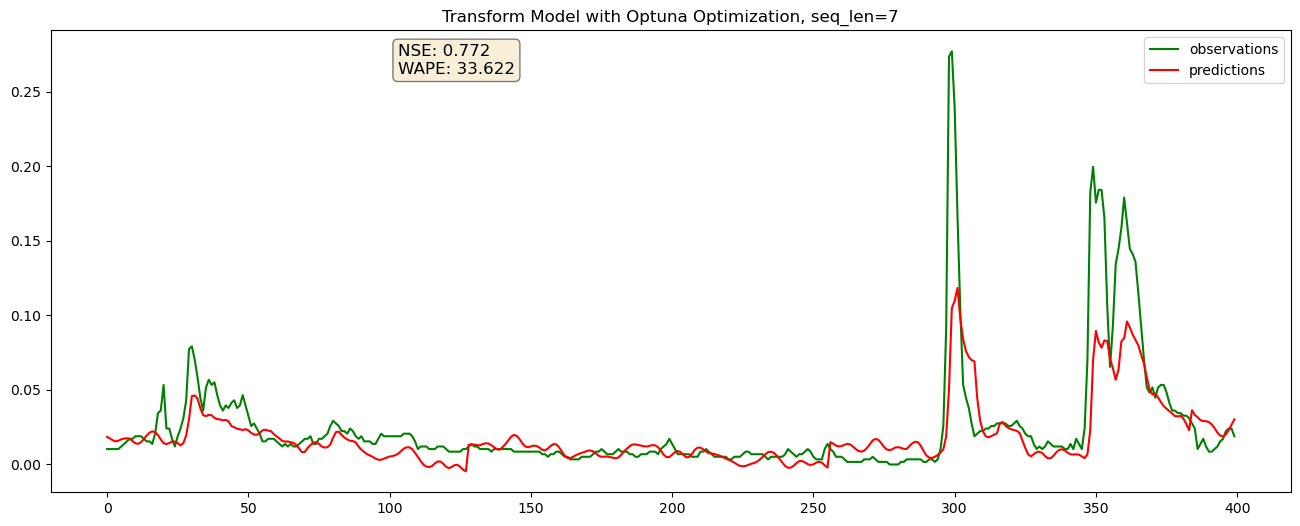

In [319]:
fig = evaluate_model(model, val_loader, plot=True) # was 'test_loader' before